# Identifying the Highs of Closing Price

# Imports 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import numpy as np

import yfinance as yf
import datetime as dt
from datetime import date
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, roc_auc_score

from scipy.signal import savgol_filter, argrelmin, argrelmax 

import warnings
warnings.filterwarnings("ignore")

# Bitcoin Dataset from Yahoo Finance

In [2]:
# Here we create the present date as the end date for our yahoo finance end day.
today = date.today().strftime('%Y-%m-%d')
today

'2020-06-10'

In [3]:
# We will grab our data from Yahoo Finance
# We have to set a start date for the first initial data and th end date.
data = yf.Ticker('BTC-USD')
bit_data = data.history(start='2018-01-01',end=today)

In [4]:
bitcoin = bit_data

In [5]:
bitcoin.shape

(892, 7)

In [6]:
bitcoin.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-06-06,9664.90,9773.43,9591.02,9653.68,20438419222,0,0
2020-06-07,9653.00,9768.50,9458.15,9758.85,25015250846,0,0
2020-06-08,9760.06,9782.31,9675.89,9771.49,21486346312,0,0
2020-06-09,9774.36,9836.37,9664.72,9795.70,23717842783,0,0
2020-06-10,9793.56,9906.04,9740.84,9871.35,25532358656,0,0


In [7]:
# Dropping 'Dividends' , 'Stock Splits' because they contain NO data.
bitcoin.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

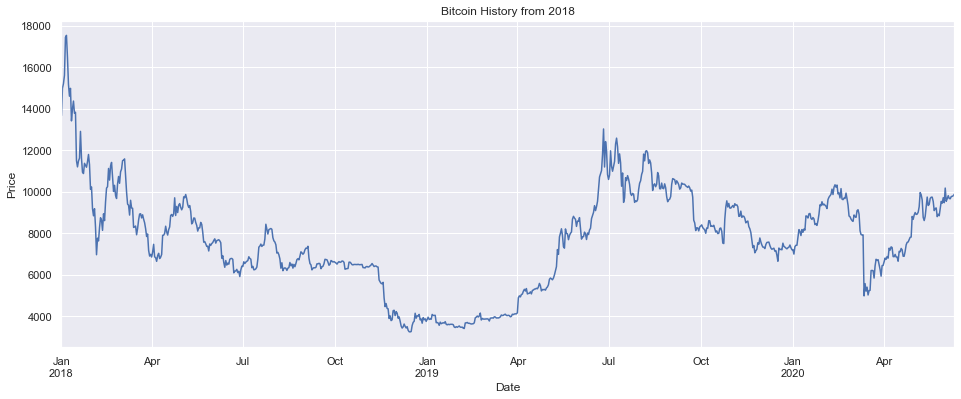

In [8]:
# Lets see our data
plt.figure(figsize=(16,6))
bitcoin.Close.plot()
plt.title('Bitcoin History from 2018')
plt.ylabel('Price');

## Smooth out the data and remove noise

### **savgol_filter**
- will smooth out our data points and make the graph less volatile.

https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.savgol_filter.html

In [ ]:
# We create a new columns and start with with a 0 int. 
# savgol_filter will smooth out the data 
# polyorder(int) will be how smooth you want the data. (lower = more smooth)/(high = less smooth)
# Window will be the length we want to filter (must be odd int.)
window = 9
bitcoin['smooth'] = savgol_filter(bitcoin.Close, window, polyorder=6)

In [ ]:
# less sharpness of points and visually less volatile than their original values
plt.figure(figsize=(16,8))
bitcoin.Close.plot()
bitcoin.smooth.plot(label='Price Line')
plt.ylabel('Closing Prices')
plt.title('Closing Prices 2018-Present', fontsize=15)
plt.legend()
# plt.savefig('bitcoin_graph', transparent =True);

In [ ]:
# Here we can see that the smooth column is a bit off compared to the Close column. 
# Smooth column represents Close price, but smoother or a bit less stiff
bitcoin.tail(15)

### argrelmin
https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.argrelmin.html
### argrelmax
https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.argrelmax.html#scipy.signal.argrelmax

- argrelmin/max: will find the minima/maxima 
- order is the amount of data points to the left and right. (the amount of adjacent points)

In [ ]:
# we will create a new column in the dataframe and set all values to 0
# order: amount of array in which to find the relative minima
# selecting the [0], turns type numpy.ndarray(tuple does not have .tolist meth.). Turn to list type

min_ids = 'min_ids'
max_ids = 'max_ids'
bitcoin[max_ids] = 0
bitcoin[min_ids] = 0

min_id = argrelmin(bitcoin.smooth.values, order=10)[0].tolist()
max_id = argrelmax(bitcoin.smooth.values, order=10)[0].tolist()

# .iloc the min/max and turn them to 1, to indicate if they are low/high price point
# all other data will be 0 if they are not low/high indicators 
bitcoin[min_ids].iloc[min_id] = 1
bitcoin[max_ids].iloc[max_id] = 1

In [ ]:
bitcoin.tail(30)

In [ ]:
plt.figure(figsize=(14,6))
bitcoin.smooth.plot(label='Smoothed price')
(5000*bitcoin.max_ids).plot(color='green', label='High Indicators')
plt.title('The Indicators', fontsize=20)
plt.ylabel('Price', fontsize=15)
plt.legend(fontsize=15);

# Baseline Model
## LogisticRegression Model: target: max_ids (High Close Price) Best Buy Price

In [ ]:
features_list = bitcoin.drop(columns=['Open', 'High', 'Low', 'Close', 'max_ids']).columns.tolist()
features_list

In [ ]:
X = bitcoin[features_list]
y = bitcoin['max_ids']

In [ ]:
scaler = preprocessing.RobustScaler().fit(X)
LogReg = LogisticRegression(penalty='l2', class_weight='balanced', random_state=42, solver='lbfgs', C=5.0)
pipe = make_pipeline(scaler, LogReg)

# Here we use a roc_auc to score the ability to distinguish the difference between target
scores = cross_val_score(pipe, X, y, n_jobs=-1, cv=4, scoring='roc_auc')
scores.mean(), scores.std()

In [ ]:
scores = cross_val_score(pipe, X, y, n_jobs=-1, cv=4, scoring='accuracy')
scores.mean(), scores.std()

----------------------------------------------------------------------------------------------------------

# Feature Engineering

- MACD: Moving Average Convergence Divergence
    - Subtracts the 26-period Expoential Moving Average(EMA) from the 12-period (EMA). 
    - https://www.investopedia.com/terms/m/macd.asp
- Std: of rolling (n)windows
    - this will give us a standard deviation of (n)windows from the mean.
- RSI: Relative Strength Index
    - this is a momentum indicator.
    - the standard period is 14(days)
    - calulates the average gain and lose for a period of time
    - values 0 - 100
    - https://www.investopedia.com/terms/r/rsi.asp
- EWM: Exponential Weighted function
    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html

In [ ]:
# the window we will use is a 5 and 10 day window
# we will find the avg. of these windows and subtract 
windows = [5, 10]

for w in windows:
    rm = bitcoin.Close.rolling(w).mean()
    bitcoin['MACD_'+str(w)] = rm - bitcoin.Close
    bitcoin['Std_'+str(w)] = bitcoin.Close.rolling(w).std()    
    
    
# the rsi_period will be our standard 14 day window
# Out of the 14 day period. We want to know what are the gains and losses
# 1. we will need to know the diff(1) of two diff. days periodically. 
# 2. we use mask to hide any data that is not a gain 
    # - this will hide the losses and 0 changes.
# 3. this is the same for our loss, hide anything that is not a loss

rsi_period = 14
change = bitcoin.Close.diff(1)
gain = change.mask(change<0,0)
loss = change.mask(change>0,0)

# here we use EWM to find the gain/loss with a period of time
# min_periods: will be our standard 14 day period
# com: is the period that we want to weight in
    # - we want to use the 14 day period, but compare the avg. gain/loss to the original close price
    # - hence why we subtract 1, taking the initial closing price out of the equation since we are
    # using it as a comparison
# we will do this for the gain and loss averages.
avg_gain = gain.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
avg_loss = loss.ewm(com=rsi_period-1, min_periods=rsi_period).mean()

# here we find the absolute value of the relative strength for the gain and loss
rs = abs(avg_gain/avg_loss)

# this is the equation/math for RSI
# we will subtract it from 100 since the scale is 0-100.
rsi = 100 - (100/(1+rs))
bitcoin['RSI'] = rsi

# after finding and creating a new RSI column, we will drop all NANs
clean_bit = bitcoin.dropna()

In [ ]:
clean_bit.shape
# we did lose a bit of information from dropping NaNs, but that's okay.

### Setting up a binary classifier for RSI

In [ ]:
# here we create new columns to help us identify if the RSI is >=70 or <=30
# initially we just want the columns to be all 0, we will change this later
# we call upon the new column and .loc the 'RSI' with a bool statement
# if the statement is True then we will identify it as a 1, if not then it will remain a 0

rsi_70 = 'RSI_70'
rsi_30 = 'RSI_30'
clean_bit[rsi_70] = 0
clean_bit[rsi_30] = 0
clean_bit[rsi_70].loc[bitcoin['RSI'] >=70] = 1
clean_bit[rsi_30].loc[bitcoin['RSI'] <=30] = 1

In [ ]:
# we can see that our binary classifying worked
clean_bit.tail()

In [ ]:
clean_bit.head(20)

## High Close Predictions + New Features

In [ ]:
# for the high, we're going to switch our the y(target)
features_list2 = clean_bit.drop(columns=['Open', 'High', 'Low', 'Close', 'max_ids']).columns.tolist()
X = clean_bit[features_list2]
y = clean_bit['max_ids']

In [ ]:
scaler = preprocessing.RobustScaler().fit(X)
LogReg = LogisticRegression(penalty='l2', class_weight='balanced', random_state=42, solver='lbfgs', C=5.0)
pipe = make_pipeline(scaler, LogReg)

# Here we use a roc_auc to score the ability to distinguish the difference between target
scores = cross_val_score(pipe, X, y, n_jobs=-1, cv=4, scoring='roc_auc')
scores.mean(), scores.std()

In [ ]:
scores = cross_val_score(pipe, X, y, n_jobs=-1, cv=4, scoring='accuracy')
scores.mean(), scores.std()

In [ ]:
high_preds = cross_val_predict(pipe, X, y, n_jobs=-1, cv=5)
clean_bit['high_preds'] = high_preds.tolist()

In [ ]:
plt.figure(figsize=(16,8))
clean_bit.smooth.plot(label='Prices')
(4000*clean_bit.max_ids).plot(color='r', label='High Price Labels')
(3000*clean_bit.high_preds).plot(color='g', label='Predictions')
plt.ylabel('Closing Price')
plt.title('High Prediction', fontsize=20)
plt.legend(fontsize=15);
# plt.savefig('High_prices', transparent =True);

- the model did miss some high points for the true highs
- but it also found some similar highs on the graph

In [ ]:
clean_bit[['Close', 'smooth', 'max_ids', 'high_preds']].tail(10)

### RSI Graph

- 70 or higher: overbought or overvalued
- 30 or less: underbought or undervalued
- This graph can show use the flow of the stock's momentum if the value is too high or too low
- RSI can help us predict the possibility of a future drop or a raise.

In [ ]:
plt.figure(figsize=(12,6))
plt.yticks(np.arange(0,100, step=10))
clean_bit.RSI.plot()
plt.axhline(y=30, color='r')
plt.axhline(y=70, color='r')
plt.title('RSI', fontsize=15);